In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

In [2]:
# 데이터 불러오기
arr = sio.loadmat('data_person_trim.mat')

train_trim = arr['train_trim']
test_trim = arr['test_trim']
train_label = arr['train_label']
test_label = arr['test_label']

Ntrn = len(train_trim)       #Ntrn=size(train_trim,1)  # 학습데이터의 수
Ntst = len(test_trim)        #Ntst=size(test_trim,1)   # 테스트데이터의 수
Isize = test_trim.shape[1]   #Isize=size(train_trim,2) # 입력벡터의 차원
Mcls = 50                    #Mcls = 50                # 클래스의 수

X=train_trim;                            # 학습데이터 행렬

Ntrn, Ntst, Isize, Mcls, train_label.shape

(150, 300, 2000, 50, (1, 150))

In [3]:
# 특징 물러오기

W  = np.load('feature_person_W.npy')
Y  = np.load('feature_person_Y.npy')
Yt = np.load('feature_person_Yt.npy')
Z  = np.load('feature_person_Z.npy')
Zt = np.load('feature_person_Zt.npy')
Vf = np.load('feature_person_Vf.npy')

dy = np.zeros((Ntrn))
dz = np.zeros((Ntrn))

W.shape, Y.shape, Yt.shape, Z.shape, Zt.shape, Vf.shape, dy.shape, dz.shape


((2000, 150),
 (150, 68),
 (300, 68),
 (150, 68),
 (300, 68),
 (68, 68),
 (150,),
 (150,))

In [4]:
dy = np.zeros((Ntrn))
dz = np.zeros((Ntrn))
min_labely = np.zeros((1,Ntst))
min_labelz = np.zeros((1,Ntst))
classification_ratey = np.zeros((Mcls))
classification_ratez = np.zeros((Mcls))

dy.shape, dz.shape, min_labely.shape, min_labelz.shape

((150,), (150,), (1, 300), (1, 300))

In [5]:
#+++ 가능한 모든 특징 차원에 대하여 반복 수행
for dim in range(Mcls-1):      #=1:Mcls-1:        
    
    Wo, Wi= np.linalg.qr(W[:,0:(dim+1)]);           # 변환행렬의 직교화
    Y=np.transpose(np.dot(Wo.T, X.T));           # PCA에 의한 차원축소 (학습데이터)
    Yt=np.transpose(np.dot(Wo.T, test_trim.T));  # PCA에 의한 차원축소 (테스트데이터)
    #print(Mcls, dim)

    #+++ 각 테스트데이터에 대해 분류 시작
    for i in range(Ntst):  #=1:Ntst:            
        
        yt=Yt[i,:];             # 테스트데이터에 대한 PCA 특징
        zt=Zt[i,0:(dim+1)];         # Yt(:,i); % 테스트데이터에 대한 LDA 특징

        # 학습데이터들과의 거리계산
        for j in range(Ntrn): #=1:Ntrn            
            dy[j] = np.linalg.norm(yt - Y[j,0:(dim+1)] )  # PCA 특징을 사용한 경우
            dz[j] = np.linalg.norm(zt - Z[j,0:(dim+1)] )  # LDA 특징을 사용한 경우
        
        miniy=np.argmin(dy);           # 최근접이웃 찾기 (PCA 특징)
        miniz=np.argmin(dz);           # 최근접이웃 찾기 (LDA 특징) 
        
        #print(i, 'miniy:', miniy, 'miniz:', miniz)
        #print(i, min_labely.shape, train_label.shape)
        
        min_labely[0,i]=train_label[0, miniy]; # 최근접이웃의 클래스로 할당 (PCA)
        min_labelz[0,i]=train_label[0, miniz]; # 최근접이웃의 클래스로 할당 (LDA)
    #--- 각 테스트데이터에 대해 분류 시작

    
    T = min_labely - test_label
    error_labely = np.array([val for val in T[0] if val != 0 ])   # error_labely=find(min_labely-test_label); %분류율 계산 (PCA)
    correcty= Ntst - error_labely.shape[0]             #    correcty=Ntst-size(error_labely,2)
    classification_ratey[dim]=correcty / Ntst;

    #error_labelz=find(min_labelz-test_label);
    T = min_labelz - test_label
    error_labelz = np.array([val for val in T[0] if val != 0 ])  # 분류율 계산 (LDA)
    correctz = Ntst - error_labelz.shape[0]             # correctz=Ntst-size(error_labelz,2);
    classification_ratez[dim]=correctz / Ntst;            #    classification_ratez(dim)=correctz/Ntst;


#    [classification_ratey(dim), classification_ratez(dim)]
#    [classification_ratey(dim), classification_ratez(dim)]

#--- 가능한 모든 특징 차원에 대하여 반복 수행

print(error_labely.shape, error_labely, error_labely.shape[0])
print(error_labelz.shape, error_labelz, error_labelz.shape[0])


(39,) [  2.  -1.  10.  10.  44.  10.  27.  -3.  -3.  -3.  -3.  32.  32.  18.
  18.   6.  11.  17.  10.  10.  -6.  -6.  -6.  17. -22. -22. -11.   4.
   4.   3.  -3.   3. -28. -18. -38. -38.   2. -18. -17.] 39
(38,) [ -1.  -1.  10.  10.  44.  44.   1.  27.  27.  25.  -3.  -3.  -3.  10.
   5.  18.  31.   6.  11.  14. -24.  -6. -11. -22. -22. -11.   1.   4.
   3.   3.  -3.   3.   9.   9.   5. -18. -45. -17.] 38


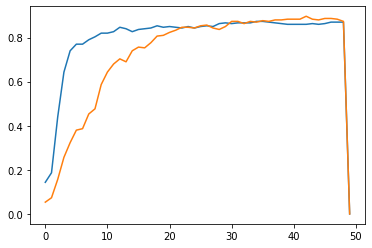

In [6]:
T = [var for var in range(50) if var>-1]
plt.plot(T,classification_ratey)
plt.plot(T,classification_ratez)
